In [1]:
# поклюячаем требуемые библиотеки
using Turing
using DifferentialEquations

# используем StatsPlots для графики
using StatsPlots

using LinearAlgebra

# Устанавливаем генератор для воспроизодимости
using Random
Random.seed!(14);

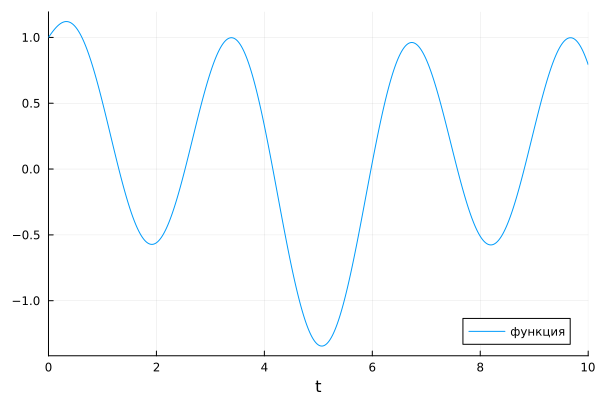

In [193]:
# Задаем линейное дифференциальное уравнения первого порядка с постоянными коэффициентами
ode_fn(y,p,x) = sin(x) + 3.0* cos(2.0 * x) - p*y


# Задаем параметр
p = 2.4

# Задаем интервал
tspan = (0.0, 10.0)

# Задаем начальное значение
y_init = 1.0

prob = ODEProblem(ode_fn, y_init, tspan, p)

num_sol = solve(prob, Tsit5(), reltol=1e-8, abstol=1e-8; p=p)

# Выводим график решения
plot(num_sol, label="функция")

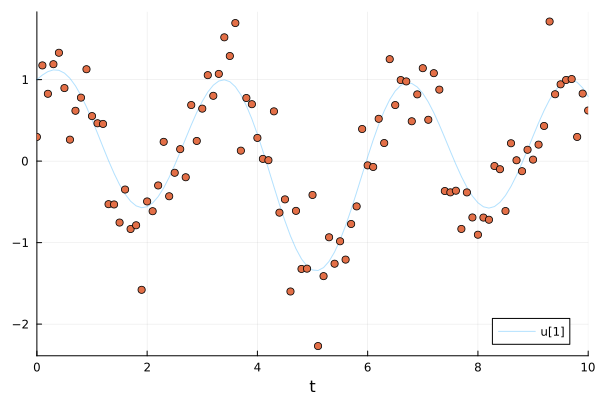

In [194]:
# Генерируем шум
sol = solve(prob, Tsit5(); saveat=0.1)
odedata = Array(sol) + 0.4 * randn(size(Array(sol)))

#отображаем на оригинальном графике точки измерения с шумом
plot(sol; alpha=0.3)
scatter!(sol.t, odedata; color=2, label="")

In [195]:
# Создаем модель 
@model function fitlv(data, prob)
    # Prior distributions.
    σ ~ InverseGamma(2, 3)
    
    p ~ truncated(Normal(1.5, 0.2), 1, 3.5)
    predicted = solve(prob, Tsit5(); p=p, saveat=0.1)

    # Observations.
    for i in 1:length(predicted)
        data[i] ~ Normal(predicted[i], σ^2 )
    end

    return nothing
end

fitlv (generic function with 2 methods)

In [196]:
# анализируем параметр на оригинальных данных без шума
orig_data_model = fitlv(sol.u, prob)

chain = sample(orig_data_model, NUTS(0.65), MCMCSerial(), 1000, 3; progress=false)

┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2


Chains MCMC chain (1000×14×3 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 15.13 seconds
Compute duration  = 15.07 seconds
parameters        = σ, p
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           σ    0.0176    0.0010    0.0000    551.0507    396.4396    1.0091   ⋯
           p    2.3999    0.0001    0.0000   2553.8593   1833.6794    1.0006   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

         

In [ ]:
# значение  p = 2.4002. Дельта равна 0.0002

In [199]:
# анализируем параметр на данных с шумом
noise_data_model = fitlv(odedata, prob)

chain = sample(noise_data_model, NUTS(0.65), MCMCSerial(), 1000, 3; progress=false)

┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.2
┌ Info: Found initial step size
└   ϵ = 0.05


Chains MCMC chain (1000×14×3 Array{Float64, 3}):

Iterations        = 501:1:1500
Number of chains  = 3
Samples per chain = 1000
Wall duration     = 2.94 seconds
Compute duration  = 2.9 seconds
parameters        = σ, p
internals         = lp, n_steps, is_accept, acceptance_rate, log_density, hamiltonian_energy, hamiltonian_energy_error, max_hamiltonian_energy_error, tree_depth, numerical_error, step_size, nom_step_size

Summary Statistics
  parameters      mean       std      mcse    ess_bulk    ess_tail      rhat   ⋯
      Symbol   Float64   Float64   Float64     Float64     Float64   Float64   ⋯

           σ    0.6347    0.0238    0.0005   2450.7765   2181.5373    1.0009   ⋯
           p    2.0992    0.1157    0.0023   2549.8878   2070.6470    1.0056   ⋯
                                                                1 column omitted

Quantiles
  parameters      2.5%     25.0%     50.0%     75.0%     97.5% 
      Symbol   Float64   Float64   Float64   Float64   Float64 

           σ

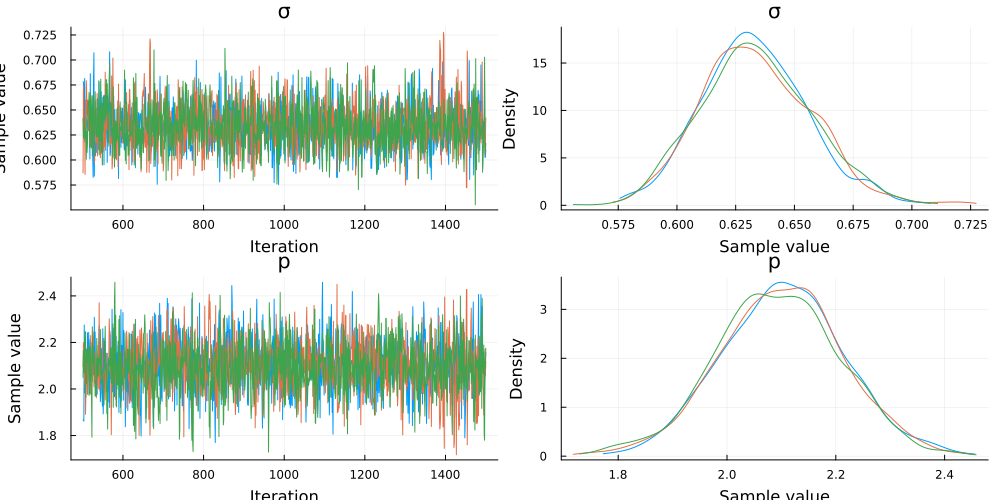

In [198]:
#визуальная оценка сходимости цепочек
plot(chain)

In [ ]:
# значение  p = 2.3261. Дельта равна 0.0739 (при перерасчете дельта может поменяться,
# например, т.к. будут сгенерированы другие данные с шумом)
# Можно сделать выводы:
#1. чем более точные измерения, тем выше точность вычисления
#2. с хорошей точностью можно использовать байесовскую оценку дифференциальных уравнений на языке Julia 
# с пакетом Turing